<a href="https://colab.research.google.com/github/RohinSequeira/EVA6_Session9_resnets_and_higher_receptive_fields/blob/main/pytorch_custom_resnet_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Resnet Architecture

In [ ]:
#!rm -rf pytorch_cifar10

In [1]:
!pip install torch
!pip install torchsummary

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import torch
import torch.optim as optim

from torchsummary import summary
from torch.optim.lr_scheduler import StepLR, OneCycleLR, ReduceLROnPlateau

import os
import numpy as np

In [3]:
%%capture
!git clone https://github.com/RohinSequeira/pytorch_cifar10.git
!pip install albumentations==1.0.0

In [4]:
from pytorch_cifar10 import main as main
from pytorch_cifar10.model import custom_resnet as models
from pytorch_cifar10.utils import utils as utils
from pytorch_cifar10.utils.gradcam import generate_gradcam, plot_gradcam_images
from pytorch_cifar10.utils.CLR import CLR
from pytorch_cifar10.utils.OneCycle import OneCycle

## Data Loader & Albumentations

In [5]:
norm_mean,norm_std = utils.cifar10_mean_std()
train_transform, test_transform = utils.get_transforms_custom_resnet(norm_mean,norm_std)

# Extract and transform the data
train_set,test_set = utils.get_datasets(train_transform,test_transform)

# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train_set.classes

# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
train_loader,test_loader = utils.get_dataloaders(train_set,test_set)

0.0%

100.0%

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
(0.492, 0.483, 0.447) (0.247, 0.243, 0.262)


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:645: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


Displaying 10 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


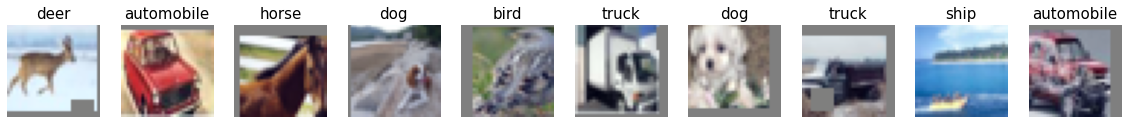

In [6]:
# Explore sample images
utils.show_sample_images(train_loader, classes, .5, .25, num_of_images = 10)

## Model Summary

In [7]:
# Model summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.ResNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

## Training & Testing the Model

In [8]:
!pip install torch-lr-finder

     |████████████████████████████████| 76 kB 3.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [15]:
from torch_lr_finder import LRFinder
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")

In [16]:
lr_finder.range_test(train_loader, val_loader=test_loader,end_lr=1, num_iter=480, step_mode="linear")

  0%|          | 0/480 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 5.17E-03


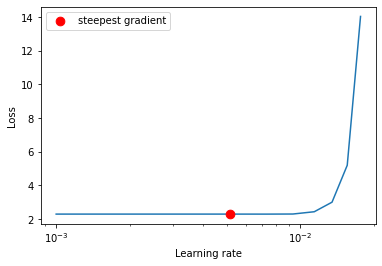

In [17]:
max_lr = lr_finder.plot(suggest_lr=True,skip_start=0, skip_end=0)

In [18]:
#lr_finder.reset()
print(max_lr[1])

0.005171189979123173


In [19]:
EPOCH = 24
batch_size = 512
l1_factor = 0
l2_factor = 0.0001
lr_value = 0.001
mt_val = 0.9

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

utils.seed_everything(1)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=max_lr[1], steps_per_epoch=len(train_loader), epochs=EPOCH, pct_start=(5.0/24.0), div_factor=10)
#scheduler = OneCycle(int(len(train_set) * EPOCH /batch_size), 0.5, prcnt=20, momentum_vals=(0.9, 0.9))

print("------------------------------------------")
train_loss, test_loss, train_acc, test_acc = main.main(EPOCH, model, device, train_loader, test_loader, optimizer, scheduler, l1_factor)

------------------------------------------

Epoch 1 : 
Train set: Average loss: 1.9009, Accuracy: 26.21

Test set: Average loss: 0.013, Accuracy: 37.77

Epoch 2 : 


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train set: Average loss: 1.0829, Accuracy: 45.10

Test set: Average loss: 0.010, Accuracy: 52.28

Epoch 3 : 
Train set: Average loss: 1.2070, Accuracy: 55.74

Test set: Average loss: 0.009, Accuracy: 60.48

Epoch 4 : 
Train set: Average loss: 1.1127, Accuracy: 63.09

Test set: Average loss: 0.007, Accuracy: 66.85

Epoch 5 : 
Train set: Average loss: 0.9757, Accuracy: 68.38

Test set: Average loss: 0.007, Accuracy: 70.80

Epoch 6 : 
Train set: Average loss: 0.7696, Accuracy: 72.13

Test set: Average loss: 0.006, Accuracy: 74.42

Epoch 7 : 
Train set: Average loss: 0.6956, Accuracy: 75.47

Test set: Average loss: 0.006, Accuracy: 75.64

Epoch 8 : 
Train set: Average loss: 0.7937, Accuracy: 77.28

Test set: Average loss: 0.005, Accuracy: 77.31

Epoch 9 : 
Train set: Average loss: 0.5702, Accuracy: 79.33

Test set: Average loss: 0.005, Accuracy: 78.08

Epoch 10 : 
Train set: Average loss: 0.4086, Accuracy: 80.55

Test set: Average loss: 0.004, Accuracy: 81.44

Epoch 11 : 
Train set: Averag

## Accuracy and Loss Plots

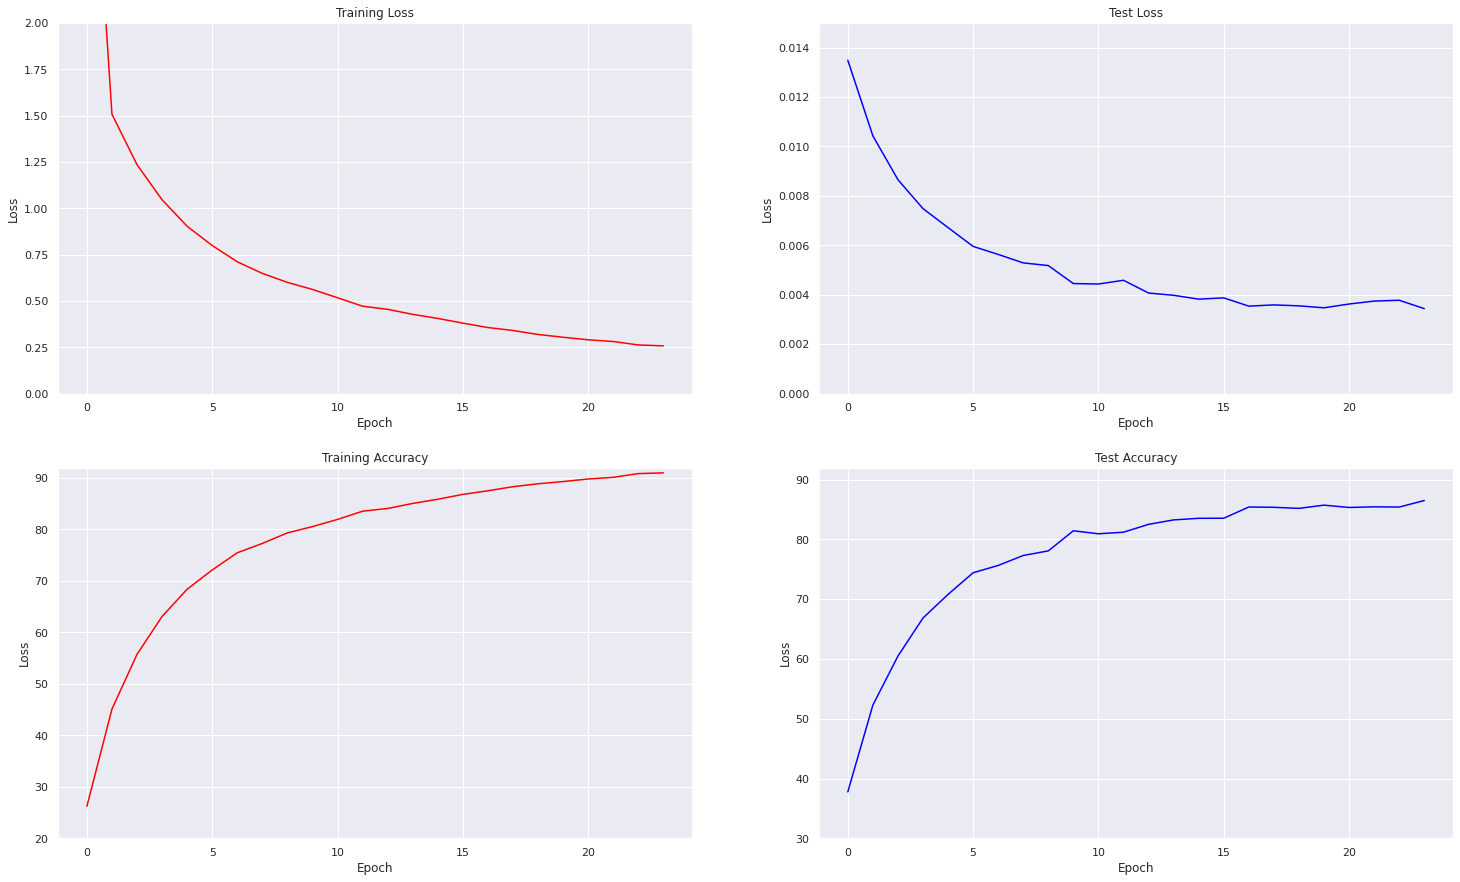

In [20]:
utils.valid_accuracy_loss_plots(train_loss, train_acc, test_loss, test_acc)

## Misclassified images

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

Total wrong predictions are 1350


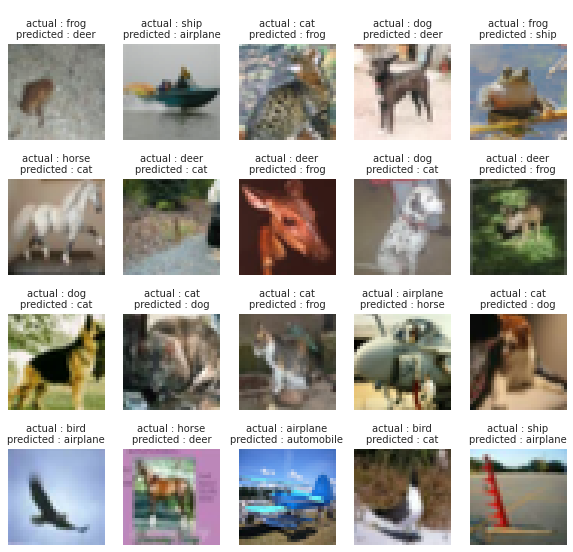

In [22]:
misclassified_images = utils.wrong_predictions(model,test_loader, norm_mean, norm_std, classes, device)

In [23]:
%%capture
target_layers = ["layer1","layer2","layer3","layer4"]
gradcam_output, probs, predicted_classes = generate_gradcam(misclassified_images[:20], model, target_layers,device)

ValueError: Invalid layer name: layer1

In [ ]:
plot_gradcam_images(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[:20])